# Individual Assignement Thomas BUI : RL agent on text flappy bird

# Set up environment

In [ ]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

In [2]:
import gymnasium as gym
import time

import text_flappy_bird_gym
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle
from collections import defaultdict
import sys

In [3]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

### Environment testing

In [4]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs, info = env.reset()

# Select next action
action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

# Appy action and return new observation of the environment
obs, reward, done, _, info = env.step(action)

obs

(12, 2)

In [ ]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(14), Discrete(22, start=-11))
Discrete(2)


Observation space : horizontal and vertical distance of the player to the closest upcoming pipe gap. Horizontal distance $\in [0, 13]$, vertical distance $\in [-12, 11]$. 

Action space : 2 actions. 0 : going down, 1 : going up. 

Hence : total number of states is $14 \times 24 = 336$. 

Rewards : reward is always 1, at each step whatever the state. Hence, aim of the agent is maximize the sum of discounted rewards before dying (when done parameter equals True). 

### Environment visualization

In [ ]:
print(env.render())

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[      @           | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=2)



## Utils functions

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_policy(policy_, v_states, agent):
    '''plot agents policies and how many time they visited each state'''
    def get_Z(x, y, dict_, p=True):
        if (x,y) in dict_:
            return dict_[x,y] if p else np.log(dict_[x,y]) 
            # number of time each state is visited in log scale
        else:
            return 0.5 if p else -1 # for policy, unseen state = 0.5
            # for number of time each state is visited, if not visited = -1

    x_range = np.arange(0, 14)
    y_range = np.arange(10, -12, -1)
    X, Y = np.meshgrid(x_range, y_range)

    def get_figure(ax): # plot policy
        Z = np.array([[get_Z(x,y,policy_) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 3), vmin=0, vmax=1, extent=[-0.5, 13.5, -11.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        ax.set_xlabel('horizontal distance to gap')
        ax.set_ylabel('vertical distance to gap')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,0.5,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (UP)','UNSEEN STATE','1 (DOWN)'])
      
    def visit(ax): # plot number of visited states
        Z = np.array([[get_Z(x,y,v_states,False) for x in x_range] for y in y_range])
        ss= ax.imshow(Z, extent=[-0.5, 13.5, -11.5, 10.5])
        ax.set_xlabel('horizontal distance to gap')
        ax.grid(color='w', linestyle='-', linewidth=1)
        cbar = plt.colorbar(ss)

    fig, axes = plt.subplots(1, 2, figsize=(18,9))
    axes[0].set_title('Policy '+agent+' control')
    get_figure(axes[0])
    visit(axes[1])
    axes[1].set_title('states visited by '+agent+' agent')

def plot_sum_rewards_episodes(rewards, agent):
    '''plot the learning curve of agent (1 point every 1000 training episode'''
    fig, ax = plt.subplots(1, figsize=(10,7))
    ax.set_title('Sum of rewards during episode '+agent)

    rewards = np.array(rewards)
    N_episodes = np.arange(0,1000*len(rewards), 1000)
    
    ax.plot(N_episodes, rewards)
    ax.set_xlabel('num episodes')
    plt.legend()

# First agent : Monte-Carlo Control with greedy policy

In [9]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ 
    generates an episode from following the epsilon-greedy policy
    
    Args : 
    - env : the TFB environment
    - Q (dict) : Q-values
    - epsilon (float) : exploring parameter
    - nA : number of possible actions (here 2)

    Output : 
    episode (list) : list of tuples containing (state, action, reward)
    one tuple for every step
     """
    episode = []

    state, info = env.reset() # init env

    while True:
        # select action following greedy-policy
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()

        # take a step in the environement 
        next_state, reward, done, _, info = env.step(action)

        # store episode data
        episode.append((state, action, reward))
        state = next_state

        if done: # end of episode
            break

    return episode

def get_probs(Q_s, epsilon, nA):
    """ 
    obtains the action probabilities corresponding to epsilon-greedy policy 
    
    Args : 
    - Q_s (list) : in state s, list of values for every action
    - epsilon (float) : exploring parameter
    - nA : number of actions

    Output : 
    policy_s (list) : in state s, list of probabilities of choosing an action
    """
    policy_s = (epsilon/nA) * np.ones(nA)
    best_a = np.argmax(Q_s)
    policy_s[best_a] = epsilon/nA + 1 - epsilon
    return policy_s

def update_Q(env, episode, Q, alpha, gamma, visited_states):
    """ 
    updates the action-value function estimate using the most recent episode 
    following Monte-Carlo control update rule
    
    Args : 
    - env : TFB environment
    - episode : data of last episode
    - Q : current value function
    - alpha, gamma : agent hyperparameters
    - visited_states (dict) : keep track of visited states
    """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])

    for i, state in enumerate(states):
        # Monte-Carlo control update rule
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha * \
        (np.sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)

        # keep track of states visited
        visited_states[state] += 1

    return Q

def evaluate_mc(env, policy_, num_episodes=100):
    '''
    evaluation function : computes a metric to measure an agent performance
    
    Args : 
    - env : TFB environment
    - policy_ (dict) : current agent policy
    - num_episodes (int) : number of episode to evaluate the agent on

    Output : 
    rewards (list) : number of steps done by the agent for every episode
    (length is num_episode). Values can't go over 1001 : from this value, 
    the agent is considered to be able to play indefinitely
    '''
    rewards = []
    for i in range(num_episodes):
      inter_reward = 0
      state, prev_info = env.reset()
      while True:
          action = policy_[state] if state in policy_ else np.random.randint(1)
          next_state, reward, done, _, info = env.step(action)
          inter_reward += 1
          if done:
              break
          if inter_reward>1000:
              break
          state = next_state
      rewards.append(inter_reward)
    return rewards

In [ ]:
def mc_control(env, num_episodes, alpha, gamma=1.0, num_rewards=1001):
    '''
    train MC control agent
    
    Args : 
    - env : TFB environment
    - num_episodes (int) : number of training episodes
    - alpha, gamma : agent hyperparameters
    - num_rewards (int) : parameter to evaluate the agent

    Output : 
    - policy (dict {state:action}) : agent policy
    - Q : value function
    - reward_track (list) : learning curve, one value per 1000 episode
    - visited_states (dict {state:n_visits}) : counts the number of time 
    each state is visited
    '''
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    visited_states = defaultdict(float)

    epsilon = 1.0
    reward_track = []

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # set the value of epsilon
        epsilon = max(epsilon*.99999, 0.05)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)

        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

            inter_policy = dict((k,np.argmax(v)) for k, v in Q.items())
            rewards_progression = evaluate_mc(env, inter_policy, num_episodes=100)

            # metric : counts the number of times the agent could go beyond
            # num_rewards over the 100 evaluating episodes
            reward_track.append(np.sum(np.array(rewards_progression)>=num_rewards))

        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma, visited_states)

    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    
    return policy, Q, reward_track, visited_states

### Determine best hyperparameters

In [ ]:
alphas = [0.01, 0.02, 0.05, 0.1, 0.5] # 10 min
gammas = [0.9, 0.95, 0.99, 1]
results = defaultdict(list)
for alp in alphas:
    for gam in gammas:
        print("\ralpha = {}, gamma = {}.".format(alp, gam), end="")
        policy, Q, rewards, _ = mc_control(env, 20000, alp, gam, num_rewards=100)
        results[(alp,gam)] = [policy, Q, rewards]

Episode 20000/20000.

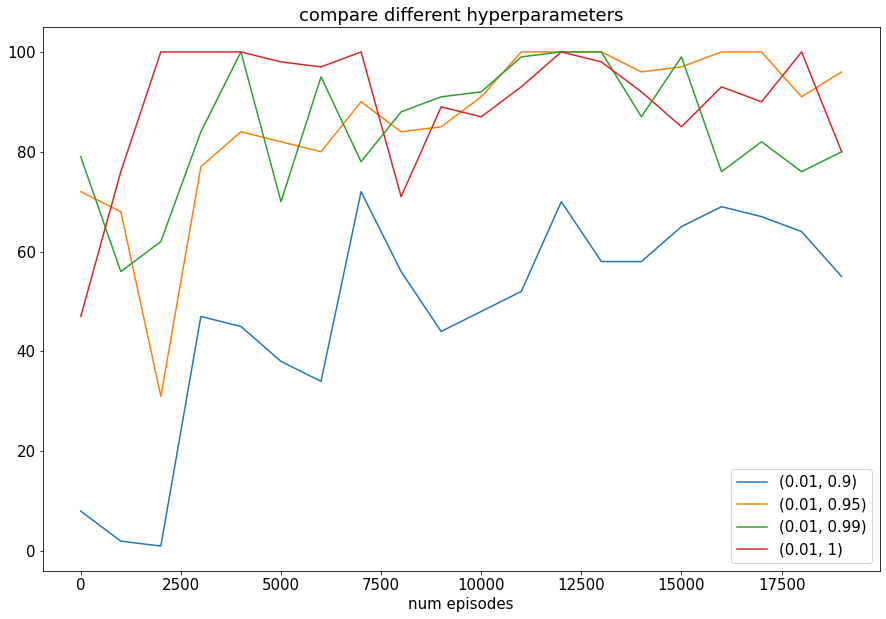

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10))
ax.set_title('compare different hyperparameters')
for k in results.keys():
    if k[0]==0.01:
      rewards = np.array(results[k][-1])
      N_episodes = np.arange(0,1000*len(rewards), 1000)
      ax.plot(N_episodes, rewards, label=k)
ax.set_xlabel('num episodes')
plt.legend()
plt.savefig('MC_hyperparameters')

### Train a Monte-Carlo Control agent

In [ ]:
policy_mc, Q_mc, rewards_mc, n_visited_states_mc = mc_control(env, 200000, 0.01, 0.95) #15min for 200000 ep

Episode 200000/200000.

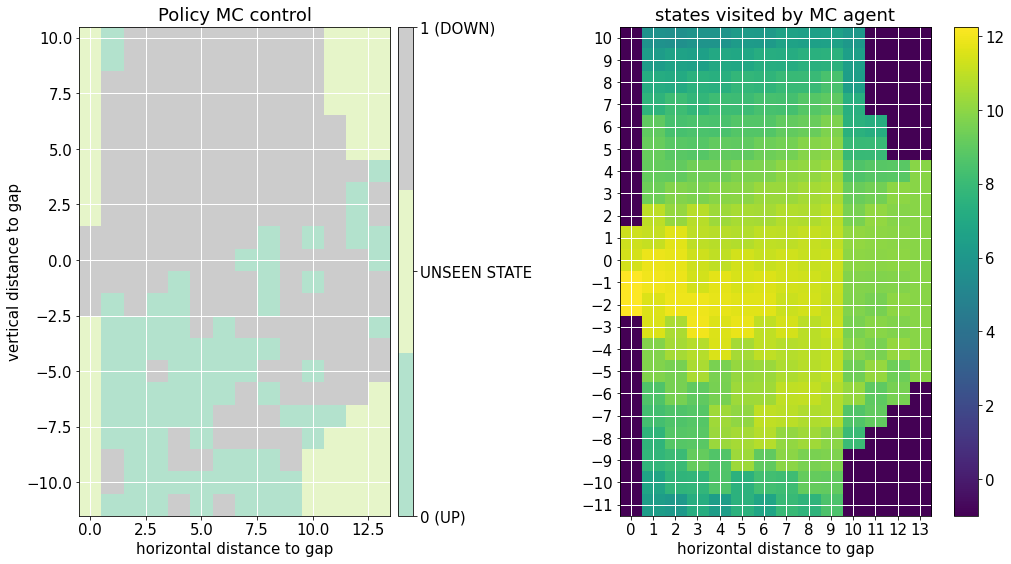

In [ ]:
plot_policy(policy_mc, n_visited_states_mc, 'MC')
plt.savefig('MC_policy')

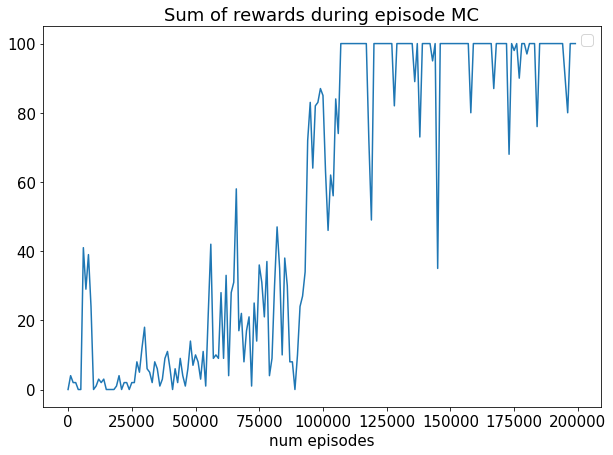

In [ ]:
plot_sum_rewards_episodes(rewards_mc, 'MC')
plt.savefig('MC_performance')

Using the policy plotted above, the Monte-Carlo control agent reached a good performance : over all 100 repeated episodes, it goes beyong 1000 steps after 200000 training episodes. 

## Expected Sarsa

In [6]:
class ExpectedSarsaAgent():
    def agent_init(self, agent_init_info):
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"] #epsilon parameter for exploration
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

        # generate dictionaries to go from array self.q (self.q[i,j] : value of action j in state i)
        # to a policy of the form {state:action}
        states = []
        for h in range(14):
            for v in range(-12,12):
                states.append((h,v))
        self.states_q = {s:i for (i,s) in enumerate(states)}
        self.q_states = {i:s for (i,s) in enumerate(states)}

        
    def agent_start(self, state_raw):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        state = self.states_q[state_raw]

        # Choose action using epsilon greedy.
        current_q = self.q[state, :]
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state_raw):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        state = self.states_q[state_raw]
        
        # Choose action using epsilon greedy.
        current_q = self.q[state,:]
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        old_Q = self.q[self.prev_state, self.prev_action]

        # epsilon greedy policy
        policy_s = (self.epsilon/self.num_actions) * np.ones(self.num_actions)
        best_a = np.argmax(self.q[state])
        policy_s[best_a] = self.epsilon/self.num_actions + 1 - self.epsilon

        # update Q using expected sarsa update rule
        self.q[self.prev_state, self.prev_action] = old_Q + self.step_size * \
        (reward + self.discount*np.sum(policy_s * self.q[state,:]) - old_Q)
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        old_Q = self.q[self.prev_state, self.prev_action]

        # expected sarsa update rule
        self.q[self.prev_state, self.prev_action] = old_Q + self.step_size * \
        (reward - old_Q)
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return np.random.choice(ties)

In [7]:
def generate_episode(env, agent, visited_states):
    '''
    generate an episode for expected sarsa agent

    Args : 
    - env : TFB agent
    - agent : ExpectedSarsaAgent instance
    - visited_states : dict tracking number of time each state is visited

    Output : 
    total_reward (int) : number of steps performed during the episode
    '''
    total_reward = 0

    # init agent
    last_state, _ = env.reset()
    last_action = agent.agent_start(last_state)

    # keep track of visited states
    visited_states[last_state]+=1

    # iterate until episode ends
    while True:
        (last_state, reward, term, _, info) = env.step(last_action)
        visited_states[last_state]+=1 # keep track of visited states
        total_reward += reward # keep track rewards

        if term:
            agent.agent_end(reward) # final update
            break
        else: # update agent
            last_action = agent.agent_step(reward, last_state) 

    return total_reward

def train_expected_sarsa(env, num_episodes, alpha, gamma=1.0, num_rewards=1000):
    '''
    train expected sarsa agent
    
    Args : 
    - env : TFB agent
    - num_episodes : number of training episodes
    - alpha, gamma : agent parameters
    - num_rewards : parameter to measure progress

    Output : 
    - policy (dict {state:action}) : agent policy
    - Q : value function
    - reward_track (list) : learning curve, one value per 1000 episode
    - visited_states (dict {state:n_visits}) : counts the number of time 
    each state is visited
    '''

    # init agent
    agent = ExpectedSarsaAgent()
    agent.agent_init({"num_actions": 2, 
              "num_states": 24*14, 
              "epsilon": 1.0, 
              "step_size": alpha, 
              "discount": gamma})

    # measure progress
    visited_states = defaultdict(float)
    reward_track = []

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # generate an episode and update agent at the same time
        r = generate_episode(env, agent, visited_states)

        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

            inter_q = np.argmax(agent.q, axis=1)
            inter_policy = dict((agent.q_states[i],inter_q[i]) for i in range(len(inter_q)))
            rewards_progression = evaluate_mc(env, inter_policy, num_episodes=100)

            # metric : counts the number of times the agent could go beyond
            # num_rewards over the 100 evaluating episodes
            reward_track.append(np.sum(np.array(rewards_progression)>=num_rewards))

    # determine the policy corresponding to the final action-value function estimate
    Q = np.argmax(agent.q, axis=1)
    policy = dict((agent.q_states[i],Q[i]) for i in range(len(Q)))
    
    return policy, Q, reward_track, visited_states

### Determine best hyperparameters

In [10]:
alphas = [0.01, 0.1, 0.5, 0.8, 1] # 13 min
gammas = [0.9, 0.95, 1]
results_sarsa = defaultdict(list)
for alp in alphas:
    for gam in gammas:
        print("\ralpha = {}, gamma = {}.".format(alp, gam), end="")
        policy, Q, rewards, _ = train_expected_sarsa(env, 10000, alp, gam, num_rewards=100)
        results_sarsa[(alp,gam)] = [policy, Q, rewards]

Episode 10000/10000.

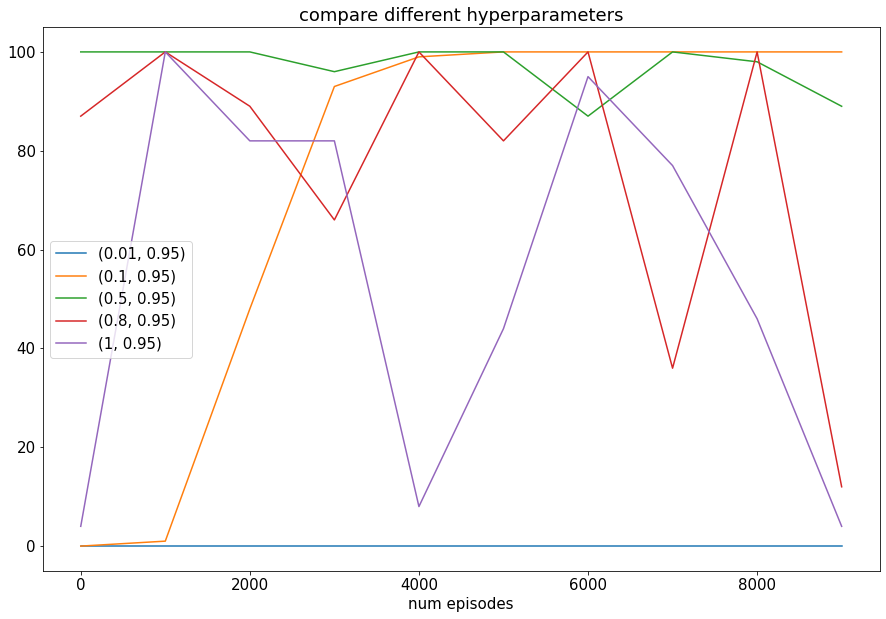

In [15]:
fig, ax = plt.subplots(1, figsize=(15,10))
ax.set_title('compare different hyperparameters')
for k in results_sarsa.keys():
    if k[1]==0.95:
      rewards = np.array(results_sarsa[k][-1])
      N_episodes = np.arange(0,1000*len(rewards), 1000)
      ax.plot(N_episodes, rewards, label=k)
ax.set_xlabel('num episodes')
plt.legend()
plt.savefig('ES_hyperparameters')

### Train an Expected Sarsa agent

In [23]:
out = train_expected_sarsa(env, 70000, 0.1, gamma=0.95, num_rewards=1000)
policy_sarsa, Q_sarsa, reward_track_sarsa, visited_states_sarsa = out

Episode 70000/70000.

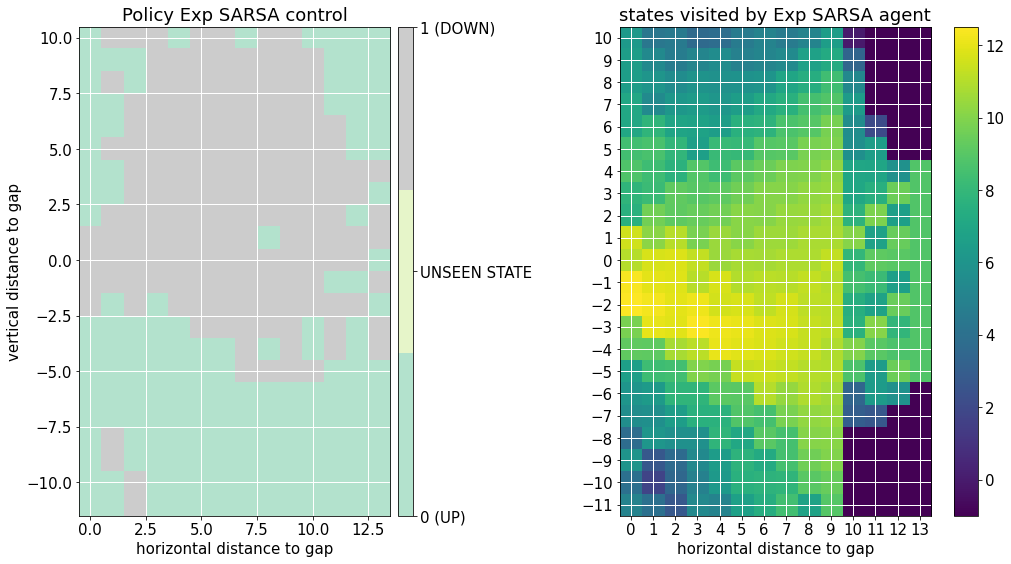

In [24]:
plot_policy(policy_sarsa, visited_states_sarsa, 'Exp SARSA')
plt.savefig('ES_policy')

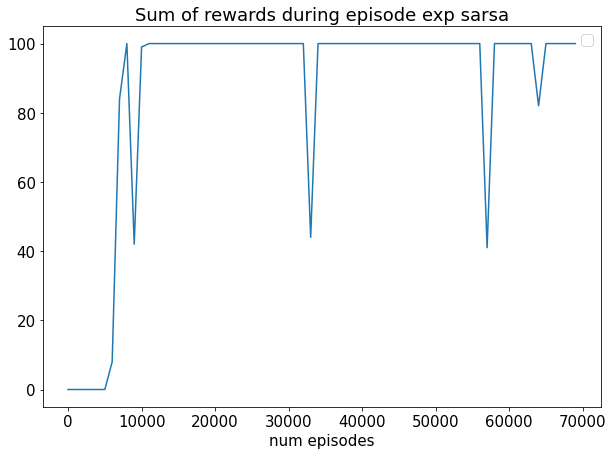

In [25]:
plot_sum_rewards_episodes(reward_track_sarsa, 'exp sarsa')
plt.savefig('ES_performance')

Using the policy plotted above, the Expected Sarsa agent reached a good performance : over all 100 repeated episodes, it goes beyong 1000 steps after only 15000 training episodes, and is much more stable than Monte-Carlo control. 

# Make agents play

In [26]:
def make_agent_play(env, policy_, max_reward):
    gameplay = []
    inter_reward = 0
    state, prev_info = env.reset()
    gameplay.append(env.render())
    while True:
        action = policy_[state] if state in policy_ else np.random.randint(1)
        next_state, reward, done, _, info = env.step(action)
        inter_reward += 1
        gameplay.append(env.render())
        if inter_reward % 1000 == 0:
            print("\rCurrent reward = {}.".format(inter_reward), end="")
        if done or inter_reward>max_reward:
            break
        state = next_state
    return gameplay, inter_reward

In [27]:
gameplay, _ = make_agent_play(env, policy_sarsa, 100000)

Current reward = 100000.

Expected Sarsa can reach 100000 steps (wich gives a final score of 100000//9 = 11111). 

In [ ]:
from IPython.display import clear_output
import time 

for render in gameplay:
  clear_output(wait=True)
  print(render)
  time.sleep(0.1)

Text Flappy Bird!
Score: 178
----------------------
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[               |    ]
[               |    ]
[      @             ]
[                    ]
[     |              ]
[     |              ]
[     |         |    ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=9,dy=-2)



KeyboardInterrupt: ignored

Making the cell above run would last 10000 seconds : approximately 3 hours. 